In [13]:
# %pip install numpy pandas tensorflow[and-cuda] scikit-learn matplotlib seaborn joblib jupyter

In [ ]:

import numpy as np
import pandas as pd
import tensorflow as tf
# จาก TensorFlow 2.16+ ควรใช้ import keras แยกต่างหาก
# แต่ Keras จะถูกติดตั้งมาพร้อมกับ tensorflow[and-cuda] อยู่แล้ว
# และ from tensorflow.keras.layers ยังคงใช้งานได้ปกติ
import keras
from tensorflow.keras import layers
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import os
import joblib # สำหรับบันทึก scaler

print("TensorFlow version:", tf.__version__)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

if tf.config.list_physical_devices('GPU'):
    print("GPU is available and detected by TensorFlow.")
    for gpu in tf.config.list_physical_devices('GPU'):
        print(f"  GPU Name: {gpu.name}")
else:
    print("No GPU detected by TensorFlow. Training will run on CPU.")


: 

In [15]:
df1 = pd.read_csv("data/dev101_prepared.csv")
df2 = pd.read_csv("data/dev102_prepared.csv")
df_all = pd.concat([df1, df2], ignore_index=True)
df_all.describe()

,devID,soil,rain,temp,humi,geo,unixt,lat,lng,rain_1h_sum,...,soil_1d_mean,geo_1h_mean,geo_3h_mean,geo_6h_mean,geo_12h_mean,geo_1d_mean,soil_diff,geo_diff,soil_1h_std,geo_1h_std
count,164466.000000,164466.000000,164466.000000,164466.000000,164466.000000,164466.000000,1.644660e+05,164466.000000,164466.000000,164466.000000,...,164466.000000,164466.000000,164466.000000,164466.000000,164466.000000,164466.000000,164466.000000,164466.000000,164466.000000,164466.000000
mean,101.513589,53.776477,0.092247,29.679459,75.856262,8.072711,1.748035e+09,8.638065,99.895333,22.694812,...,53.812939,8.097669,8.122717,8.131706,8.175906,8.198281,0.000104,0.000033,0.212697,4.609207
std,0.499817,5.954348,0.531029,3.033125,7.862898,6.715461,1.293685e+06,0.105605,0.599403,102.214009,...,5.240015,4.122324,4.070308,4.072700,4.071846,4.078390,0.133532,6.907295,0.443326,2.718295
min,101.000000,30.000000,0.000000,24.949266,49.724041,0.000000,1.746233e+09,0.083333,0.008333,0.000000,...,29.900000,0.000000,0.000000,0.000000,0.000000,0.000000,-17.700001,-31.521689,0.000000,0.000000
25%,101.000000,49.000000,0.000000,27.376595,70.564049,3.513890,1.746515e+09,8.637946,99.898933,0.000000,...,49.735621,4.111799,4.162901,4.399856,4.500379,4.567634,0.000000,-1.213978,0.074960,2.586407
50%,102.000000,53.900002,0.000000,28.236437,79.402840,4.111144,1.748635e+09,8.637970,99.898949,0.000000,...,53.189763,7.388593,7.084110,6.836436,6.539413,6.302564,0.000000,0.000000,0.110629,4.458970
75%,102.000000,58.599998,0.000000,32.188526,81.222481,12.619162,1.749138e+09,8.638009,99.898972,0.000000,...,57.998910,11.348028,11.516647,11.571721,11.748648,11.254114,0.000000,1.184657,0.212783,6.460629
max,102.000000,65.500000,7.264400,38.984512,88.510567,32.062466,1.749750e+09,48.859433,99.899544,1434.998409,...,63.666010,31.989561,31.989561,31.989561,31.989561,31.989561,13.299999,31.505789,7.738690,12.330683


In [16]:
feature_cols = [
    'soil', 'rain', 'temp', 'humi', 'geo',
]

missing = [col for col in feature_cols if col not in df_all.columns]
if missing:
    raise ValueError(f"ขาดคอลัมน์ในข้อมูลทั้งหมด: {missing}")

In [17]:
X_data = df_all[feature_cols].copy()

In [18]:
scaler = MinMaxScaler()

X_train, X_val = train_test_split(X_data, test_size=0.2, random_state=42)

scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_val_scaled = scaler.transform(X_val)

X_all_scaled = scaler.transform(X_data)


print(f"Scaled training data shape: {X_train_scaled.shape}")
print(f"Scaled validation data shape: {X_val_scaled.shape}")
print(f"Scaled full data shape (for anomaly scoring): {X_all_scaled.shape}\n")

Scaled training data shape: (131572, 5)
Scaled validation data shape: (32894, 5)
Scaled full data shape (for anomaly scoring): (164466, 5)



In [19]:
input_dim = X_train_scaled.shape[1] 
latent_dim = 2 

encoder_input = keras.Input(shape=(input_dim,))
encoded = layers.Dense(input_dim // 2, activation='relu')(encoder_input)
encoded = layers.Dense(input_dim // 4, activation='relu')(encoded)      
latent_representation = layers.Dense(latent_dim, activation='relu', name='latent_layer')(encoded) 

decoded = layers.Dense(input_dim // 4, activation='relu')(latent_representation)
decoded = layers.Dense(input_dim // 2, activation='relu')(decoded)     
decoder_output = layers.Dense(input_dim, activation='linear')(decoded) 

autoencoder = keras.Model(encoder_input, decoder_output)

autoencoder.compile(optimizer='adam', loss='mse') 

print("Autoencoder Model Summary:")
autoencoder.summary()
print("\n")

Autoencoder Model Summary:
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 5)]               0         
                                                                 
 dense_5 (Dense)             (None, 2)                 12        
                                                                 
 dense_6 (Dense)             (None, 1)                 3         
                                                                 
 latent_layer (Dense)        (None, 2)                 4         
                                                                 
 dense_7 (Dense)             (None, 1)                 3         
                                                                 
 dense_8 (Dense)             (None, 2)                 4         
                                                                 
 dense_9 (Dense)             (No

In [20]:
print("Training Autoencoder...")

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

history = autoencoder.fit(
    X_train_scaled, X_train_scaled,
    epochs=5, 
    batch_size=32,
    validation_data=(X_val_scaled, X_val_scaled),
    shuffle=True, 
    verbose=1,
    callbacks=[tensorboard_callback] 
)



Training Autoencoder...
Epoch 1/5
4112/4112 [==============================] - 5s 1ms/step - loss: 0.0461 - val_loss: 0.0331
Epoch 2/5
4112/4112 [==============================] - 5s 1ms/step - loss: 0.0332 - val_loss: 0.0331
Epoch 3/5
4112/4112 [==============================] - 4s 1ms/step - loss: 0.0332 - val_loss: 0.0331
Epoch 4/5
4112/4112 [==============================] - 4s 1ms/step - loss: 0.0332 - val_loss: 0.0331
Epoch 5/5
4112/4112 [==============================] - 5s 1ms/step - loss: 0.0332 - val_loss: 0.0331


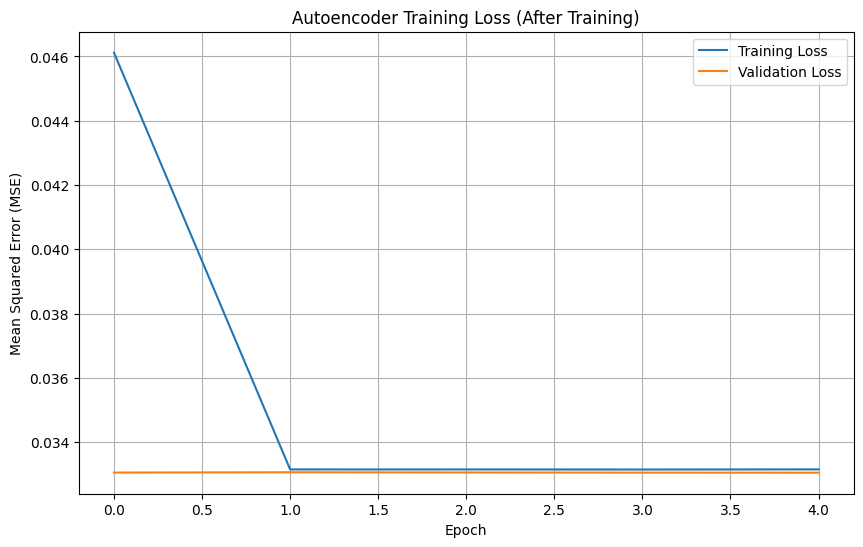

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Autoencoder Training Loss (After Training)')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error (MSE)')
plt.legend()
plt.grid(True)
plt.show()


5140/5140 [==============================] - 4s 811us/step
DataFrame with Anomaly Scores (first 10 rows):
                    timestamp  devID       soil    rain       temp       humi  \
0  2025-05-03 00:38:36.484580  101.0  30.000000  2.2352  28.714430  80.385139   
1  2025-05-03 00:38:47.952344  101.0  30.299999  2.2352  28.663694  80.211571   
2  2025-05-03 00:38:59.052205  101.0  30.600000  2.5146  28.685057  79.572594   
3  2025-05-03 00:39:10.889386  101.0  31.200001  2.5146  27.536812  85.142143   
4  2025-05-03 00:39:23.174007  101.0  31.200001  2.5146  28.161669  81.905319   
5  2025-05-03 00:39:34.879840  101.0  31.799999  2.5146  28.426033  81.203407   
6  2025-05-03 00:39:47.137918  101.0  32.500000  2.7940  28.655678  80.327919   
7  2025-05-03 00:39:59.066708  101.0  33.099998  2.7940  28.714430  80.322197   
8  2025-05-03 00:40:10.126424  101.0  33.500000  3.0734  28.845274  79.963608   
9  2025-05-03 00:40:21.956546  101.0  34.099998  3.0734  27.707714  85.531242   

  

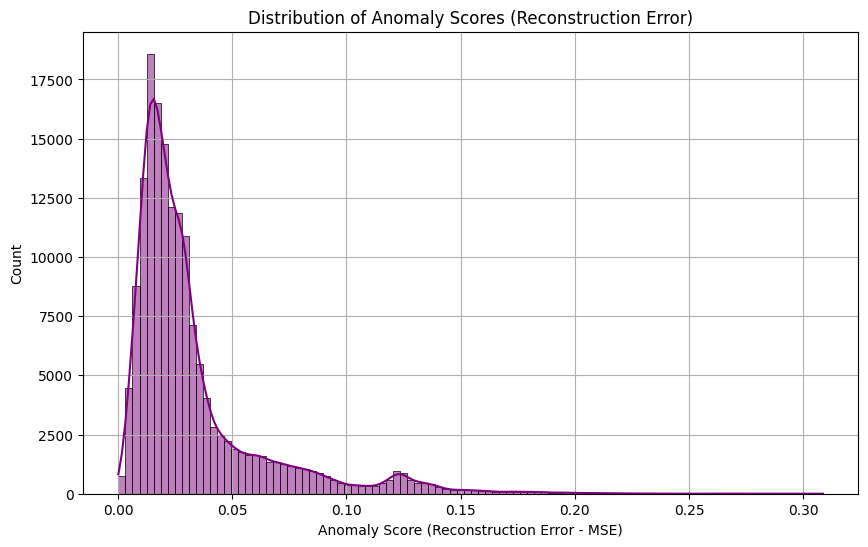

In [25]:
reconstructions = autoencoder.predict(X_all_scaled)

anomaly_scores = np.mean(np.power(X_all_scaled - reconstructions, 2), axis=1)

df_all['anomaly_score'] = anomaly_scores

print("DataFrame with Anomaly Scores (first 10 rows):")
print(df_all.head(10))

print(f"\nMinimum Anomaly Score: {anomaly_scores.min():.4f}")
print(f"Maximum Anomaly Score: {anomaly_scores.max():.4f}")
print(f"Mean Anomaly Score: {anomaly_scores.mean():.4f}")
print(f"Median Anomaly Score: {np.median(anomaly_scores):.4f}")

plt.figure(figsize=(10, 6))
sns.histplot(anomaly_scores, bins=100, kde=True, color='purple')
plt.title('Distribution of Anomaly Scores (Reconstruction Error)')
plt.xlabel('Anomaly Score (Reconstruction Error - MSE)')
plt.ylabel('Count')
plt.grid(True)
plt.show()


4112/4112 [==============================] - 3s 735us/step

Calculated Anomaly Threshold (95th percentile of training errors): 0.1046

DataFrame with Anomaly Predictions (first 10 rows):
                    timestamp  devID       soil    rain       temp       humi  \
0  2025-05-03 00:38:36.484580  101.0  30.000000  2.2352  28.714430  80.385139   
1  2025-05-03 00:38:47.952344  101.0  30.299999  2.2352  28.663694  80.211571   
2  2025-05-03 00:38:59.052205  101.0  30.600000  2.5146  28.685057  79.572594   
3  2025-05-03 00:39:10.889386  101.0  31.200001  2.5146  27.536812  85.142143   
4  2025-05-03 00:39:23.174007  101.0  31.200001  2.5146  28.161669  81.905319   
5  2025-05-03 00:39:34.879840  101.0  31.799999  2.5146  28.426033  81.203407   
6  2025-05-03 00:39:47.137918  101.0  32.500000  2.7940  28.655678  80.327919   
7  2025-05-03 00:39:59.066708  101.0  33.099998  2.7940  28.714430  80.322197   
8  2025-05-03 00:40:10.126424  101.0  33.500000  3.0734  28.845274  79.963608   
9  

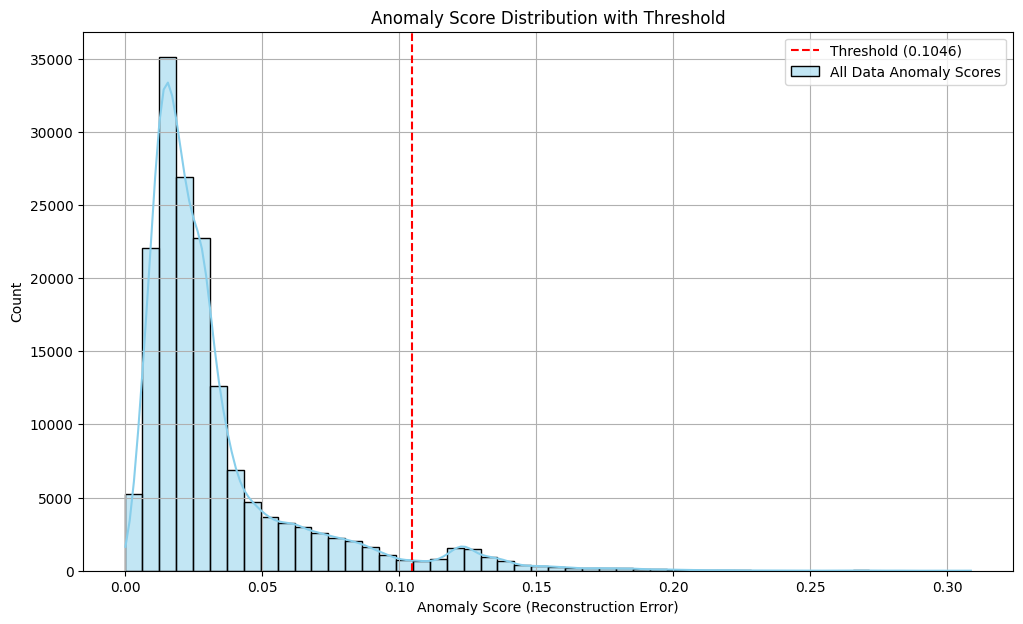


Details of 8239 predicted anomalies:
            soil    rain       temp       humi        geo  anomaly_score
37377  63.599998  6.7056  26.161592  80.738007  31.989956       0.308616
37379  63.400002  6.7056  26.132219  80.795227  32.009842       0.308449
37381  63.599998  6.7056  26.185625  80.543449  31.994568       0.308241
66     41.900002  6.4262  27.050814  85.447319  32.028179       0.304886
57     42.099998  6.4262  27.269777  85.514076  32.033386       0.303234


In [26]:
train_reconstructions = autoencoder.predict(X_train_scaled)
train_anomaly_scores = np.mean(np.power(X_train_scaled - train_reconstructions, 2), axis=1)

threshold = np.percentile(train_anomaly_scores, 95) 
print(f"\nCalculated Anomaly Threshold (95th percentile of training errors): {threshold:.4f}")

df_all['is_anomaly_predicted'] = (df_all['anomaly_score'] > threshold).astype(int)

print("\nDataFrame with Anomaly Predictions (first 10 rows):")
print(df_all.head(10))

print(f"\nNumber of predicted anomalies: {df_all['is_anomaly_predicted'].sum()}")
print(f"Percentage of predicted anomalies: {df_all['is_anomaly_predicted'].mean() * 100:.2f}%")

plt.figure(figsize=(12, 7))
sns.histplot(anomaly_scores, bins=50, kde=True, color='skyblue', label='All Data Anomaly Scores')
plt.axvline(threshold, color='red', linestyle='--', label=f'Threshold ({threshold:.4f})')
plt.title('Anomaly Score Distribution with Threshold')
plt.xlabel('Anomaly Score (Reconstruction Error)')
plt.ylabel('Count')
plt.legend()
plt.grid(True)
plt.show()

anomalies_df = df_all[df_all['is_anomaly_predicted'] == 1]
print(f"\nDetails of {len(anomalies_df)} predicted anomalies:")
print(anomalies_df[feature_cols + ['anomaly_score']].sort_values(by='anomaly_score', ascending=False).head())


In [24]:
import os
model_dir = 'models'
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

model_path = os.path.join(model_dir, './model/autoencoder_model.keras') # .keras is the recommended format

autoencoder.save(model_path)
print(f"\nAutoencoder model saved successfully to: {model_path}")

import joblib # Often used for saving scikit-learn objects

scaler_path = os.path.join(model_dir, './model/autoencoder_scaler.pkl')
joblib.dump(scaler, scaler_path)
print(f"MinMaxScaler saved successfully to: {scaler_path}")

FileNotFoundError: [Errno 2] No such file or directory: 'models\\./model/autoencoder_model.keras'

In [ ]:

import os
import joblib

model_dir = 'models'
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

# Save in HDF5 format (.h5)
model_path_h5 = os.path.join(model_dir, './model/autoencoder_model.h5')
autoencoder.save(model_path_h5)
print(f"\nAutoencoder model saved successfully to: {model_path_h5} (HDF5 format)")

# Save the scaler (still recommend joblib for scikit-learn objects)
scaler_path = os.path.join(model_dir, './model/autoencoder_scaler.pkl')
joblib.dump(scaler, scaler_path)
print(f"MinMaxScaler saved successfully to: {scaler_path}")